In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm




In [81]:
df = pd.read_csv("lego.population.csv", sep=",", encoding="latin1")
# fjerner forklaringsvariabler vi ikke trenger


df2 = df[
    ["Set_Name", "Theme", "Klassifisering", "Ages", "Price", "Pages", "Pieces",  "Unique_Pieces"]
]

# fjerner observasjoner med manglende datapunkter
df2 = df2.dropna()

klassifisering_mapping = { "B": 1, "N":0, "G": 2}
df2["Klassifisering_norm"] = df2["Klassifisering"].map(klassifisering_mapping)


# gjør themes om til string og fjern alle tegn vi ikke vil ha med
df2["Theme"] = df2["Theme"].astype(str)
df2["Theme"] = df2["Theme"].str.replace(r"[^a-zA-Z0-9\s-]", "", regex=True)

# fjerner dollartegn og trademark-tegn fra datasettet
df2["Price"] = df2["Price"].str.replace("\$", "", regex=True)

# og gjør så prisen om til float
df2["Price"] = df2["Price"].astype(float)

df2

,Set_Name,Theme,Klassifisering,Ages,Price,Pages,Pieces,Unique_Pieces,Klassifisering_norm
0,Batboat The Penguin Pursuit!,Batman,B,Ages_4+,9.99,44.0,54.0,41.0,1
1,Battle-Ready Batman and MetalBeard,Batman,B,Ages_6+,19.99,64.0,168.0,98.0,1
2,Batman vs. The Riddler Robbery,Batman,B,Ages_4+,9.99,36.0,59.0,44.0,1
3,Batman: The Attack of the Talons,Batman,B,Ages_7-12,19.99,60.0,155.0,82.0,1
4,Batman Batsub and the Underwater Clash,Batman,B,Ages_7+,19.99,64.0,174.0,82.0,1
...,...,...,...,...,...,...,...,...,...
1294,Death Star Final Duel,Star Wars,B,Ages_9+,99.99,140.0,775.0,241.0,1
1295,Resistance I-TS Transport,Star Wars,B,Ages_9+,99.99,140.0,932.0,215.0,1
1297,TIE Fighter Pilot,Star Wars,B,Ages_18+,59.99,148.0,724.0,155.0,1
1298,Y-wing Starfighter,Star Wars,B,Ages_14+,199.99,220.0,1967.0,359.0,1


In [75]:
def transform_ages(age_str):
    try:
        # Remove 'Ages_' prefix and any non-numeric characters except for '+' and '-'
        age_str = re.sub(r'Ages_|[^\d\+\-]', '', age_str).strip()
        # Split on '+' and take the first element (the actual age)
        age_str = age_str.split('+')[0]
        # Split on '-' to find ranges
        age_range = age_str.split('-')
        # If it's a range and the upper age is 99, use just the lower age
        if len(age_range) == 2 and age_range[1] == '99':
            return int(age_range[0])
        # If it's a range, calculate the average, otherwise use the single value
        elif len(age_range) == 2:
            return (int(age_range[0]) + int(age_range[1])) / 2
        else:
            return int(age_range[0])
    except ValueError as e:
        # Log the error and the problematic string
        print(f"Error converting {age_str} to int: {e}")
        return None  # Or some default value you deem appropriate
df2['Ages_norm'] = df2['Ages'].apply(transform_ages)
df2


,Set_Name,Theme,Klassifisering,Ages,Price,Pages,Pieces,Unique_Pieces,Klassifisering_norm,Ages_norm
0,Batboat The Penguin Pursuit!,Batman,B,Ages_4+,9.99,44.0,54.0,41.0,0,4.0
1,Battle-Ready Batman and MetalBeard,Batman,B,Ages_6+,19.99,64.0,168.0,98.0,0,6.0
2,Batman vs. The Riddler Robbery,Batman,B,Ages_4+,9.99,36.0,59.0,44.0,0,4.0
3,Batman: The Attack of the Talons,Batman,B,Ages_7-12,19.99,60.0,155.0,82.0,0,9.5
4,Batman Batsub and the Underwater Clash,Batman,B,Ages_7+,19.99,64.0,174.0,82.0,0,7.0
...,...,...,...,...,...,...,...,...,...,...
1294,Death Star Final Duel,Star Wars,B,Ages_9+,99.99,140.0,775.0,241.0,0,9.0
1295,Resistance I-TS Transport,Star Wars,B,Ages_9+,99.99,140.0,932.0,215.0,0,9.0
1297,TIE Fighter Pilot,Star Wars,B,Ages_18+,59.99,148.0,724.0,155.0,0,18.0
1298,Y-wing Starfighter,Star Wars,B,Ages_14+,199.99,220.0,1967.0,359.0,0,14.0


In [68]:
formel = 'Price ~ Ages_norm'

modell = smf.ols(formel, data = df2)
resultat = modell.fit()

resultat.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     320.2
Date:                Thu, 02 Nov 2023   Prob (F-statistic):           1.12e-61
Time:                        11:58:42   Log-Likelihood:                -4913.5
No. Observations:                 922   AIC:                             9831.
Df Residuals:                     920   BIC:                             9841.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.6542      4.385     -5.850      0.000     -34.260     -17.048
Ages_norm      9.4270      0.527     17.894      0.000       8.393      10.461
==============================================================================
Omnibus:                      753.692   Durbin-Watson:                   1.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27177.809
Skew:                           3.453   Prob(JB):                         0.00
Kurtosis:                      28.686   Cond. No.                         22.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

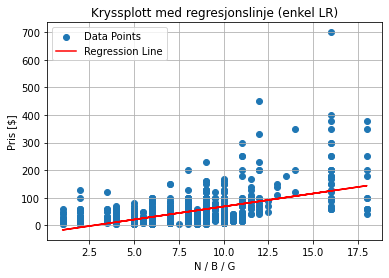

Set_Name               Imperial Star Destroyer
Theme                                Star Wars
Klassifisering                               B
Ages                                  Ages_16+
Price                                   699.99
Pages                                    444.0
Pieces                                  4784.0
Unique_Pieces                            445.0
Klassifisering_norm                          0
Ages_norm                                 16.0
Name: 1279, dtype: object


In [76]:
slope = resultat.params['Ages_norm']
intercept = resultat.params['Intercept']

regression_x = np.array(df2['Ages_norm'])

regression_y = slope * regression_x + intercept

plt.scatter(df2['Ages_norm'], df2['Price'], label='Data Points')
plt.plot(regression_x, regression_y, color='red', label='Regression Line')
plt.xlabel('N / B / G')
plt.ylabel('Pris [$]')
plt.title('Kryssplott med regresjonslinje (enkel LR)')
plt.legend()
plt.grid()
plt.show()

print(df2.loc[df2['Price'].idxmax()])

In [6]:
print(len(df2['Klassifisering_norm']))
print(len(df2['Price']))
print(len(df2['Pieces']))

922
922
922


In [77]:
# multippel lineær regresjon
modell3_mlr = smf.ols('Price ~ Pieces + Klassifisering_norm + Ages_norm ' , data = df2)
results_mlr = modell3_mlr.fit()
summary_mlr = results_mlr.summary()

#Normalize the data, feks b g can only be 0 , 1 or 2
summary_mlr

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1862.
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:04:54   Log-Likelihood:                -4148.5
No. Observations:                 922   AIC:                             8305.
Df Residuals:                     918   BIC:                             8324.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              19.4813      2.263      8.610      0.000      15.041      23.922
Pieces                  0.0906      0.001     62.412      0.000       0.088       0.093
Klassifisering_norm    -3.0371      0.940     -3.232      0.001      -4.882      -1.193
Ages_norm              -1.3232      0.291     -4.552      0.000      -1.894      -0.753
==============================================================================
Omnibus:                      704.865   Durbin-Watson:                   1.269
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45552.689
Skew:                           2.885   Prob(JB):                         0.00
Kurtosis:                      36.948   Cond. No.                     2.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

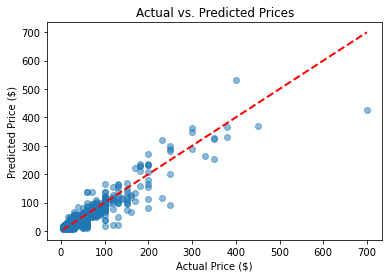

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     2732.
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:08:52   Log-Likelihood:                -4157.7
No. Observations:                 922   AIC:                             8321.
Df Residuals:                     919   BIC:                             8336.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.7689      1.429      4.037      0.000       2.965       8.573
Pieces                  0.0875      0.001     73.747      0.000       0.085       0.090
Klassifisering_norm     3.1235      1.116      2.799      0.005       0.934       5.314
==============================================================================
Omnibus:                      737.023   Durbin-Watson:                   1.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44856.684
Skew:                           3.127   Prob(JB):                         0.00
Kurtosis:                      36.593   Cond. No.                     1.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
df2['Predicted_Price'] = results_mlr.predict(df2[['Pieces', 'Klassifisering_norm']])

plt.scatter(df2['Price'], df2['Predicted_Price'], alpha=0.5)
plt.plot([df2['Price'].min(), df2['Price'].max()], 
         [df2['Price'].min(), df2['Price'].max()], 
         '--', color='red', linewidth=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs. Predicted Prices')
plt.show()

summary_mlr


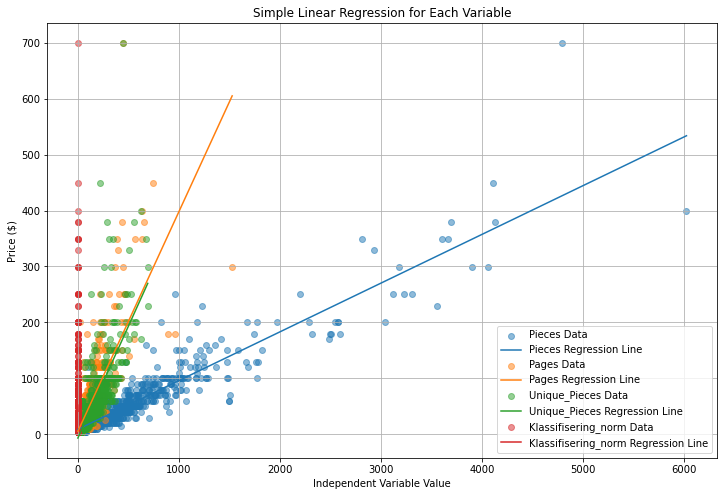

In [29]:
def simple_linear_regression(data, independent_var, dependent_var='Price'):
    # Define the formula for OLS regression
    formula = f'{dependent_var} ~ {independent_var}'
    # Fit the model
    model = smf.ols(formula, data=data).fit()
    return model

def plot_regression_line(data, independent_var, dependent_var='Price', model=None):
    if model is None:
        model = simple_linear_regression(data, independent_var, dependent_var)
    
    # Create a range of values for the independent variable
    x_range = np.linspace(data[independent_var].min(), data[independent_var].max(), 100)
    # Predict the dependent variable for the range of independent variable values
    y_range = model.params['Intercept'] + model.params[independent_var] * x_range
    
    # Plot the data points
    plt.scatter(data[independent_var], data[dependent_var], alpha=0.5, label=f'{independent_var} Data')
    # Plot the regression line
    plt.plot(x_range, y_range, label=f'{independent_var} Regression Line')



variables = ['Pieces', 'Pages', 'Unique_Pieces', "Klassifisering_norm"]
plt.figure(figsize=(12, 8))
for var in variables:
    model = simple_linear_regression(df2, var)
    plot_regression_line(df2, var, model=model)
plt.xlabel('Independent Variable Value')
plt.ylabel('Price ($)')
plt.title('Simple Linear Regression for Each Variable')
plt.legend()
plt.grid(True)
plt.show()
